# IMPORTS

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import os 
import time 
from itertools import product

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

# READ THE DATA

In [4]:
item_categories = pd.read_csv('./input/item_categories.csv')
items = pd.read_csv('./input/items.csv')
sales = pd.read_csv('./input/sales_train.csv')
shops = pd.read_csv('./input/shops.csv')
test = pd.read_csv('./input/test.csv')

In [5]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
LINEWIDTH = 2
ALPHA = .6

In [6]:
dfp = sales[['date', 'date_block_num', 'item_cnt_day']].copy()

dfp['date'] = pd.to_datetime(dfp['date'], format='%d.%m.%Y')
dfp['year'] = dfp['date'].dt.year
dfp['month'] = dfp['date'].dt.month
dfp.drop(['date'], axis=1, inplace=True)

In [7]:
dfp = dfp.groupby('date_block_num', as_index=False)\
       .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

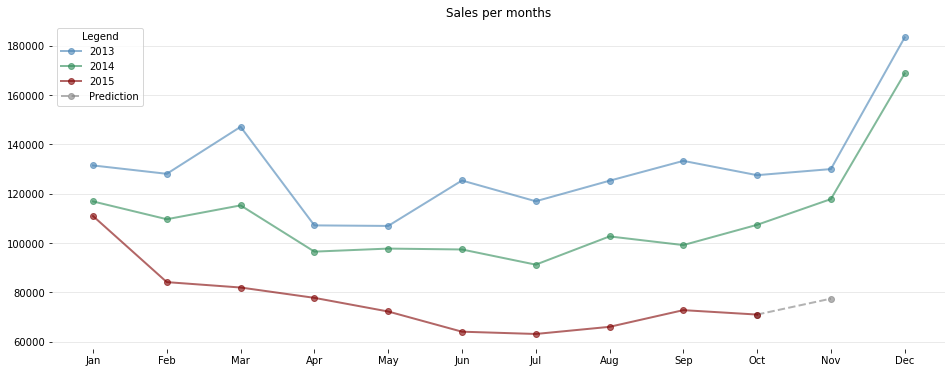

In [8]:
plt.figure(figsize=(16,6))
plt.plot(MONTHS, dfp[dfp.year==2013].item_cnt_month, '-o', color='steelblue', linewidth=LINEWIDTH, alpha=ALPHA,label='2013')

# Plot the sales of the year 2014
plt.plot(MONTHS, dfp[dfp.year==2014].item_cnt_month, '-o', color='seagreen', linewidth=LINEWIDTH, alpha=ALPHA,label='2014')

# Plot the sales of the year 2015 until October
plt.plot(MONTHS[:10], dfp[dfp.year==2015].item_cnt_month, '-o', color='maroon', linewidth=LINEWIDTH, alpha=ALPHA,label='2015')

# Capturing the trend between October and November (For year 2013 and 2014)
delta_2013 = dfp.iloc[10].item_cnt_month - dfp.iloc[9].item_cnt_month
delta_2014 = dfp.iloc[22].item_cnt_month - dfp.iloc[21].item_cnt_month
avg_delta = (delta_2013 + delta_2014) / 2
# Add the average to the previous month (October 2015)
nov_2015 = dfp.iloc[33].item_cnt_month + avg_delta

# MONTHS[9:11] equals ['Oct', 'Nov']
plt.plot(MONTHS[9:11], [dfp.iloc[33].item_cnt_month, nov_2015], '--o', color='gray', linewidth=LINEWIDTH, alpha=ALPHA, label='Prediction', zorder=-1)

ax = plt.gca()
ax.set_title('Sales per months')
ax.set_label('# of items')
ax.grid(axis='y', color='gray', alpha=.2)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=2, title='Legend')
plt.show()

del dfp


2013: the total of the top 15 best selling items is 1304004 over a total of 1565897 for that year, which represents 83.28%
2014: the total of the top 15 best selling items is 1048377 over a total of 1323594 for that year, which represents 79.21%
2015: the total of the top 15 best selling items is 580259 over a total of 766256 for that year, which represents 75.73%


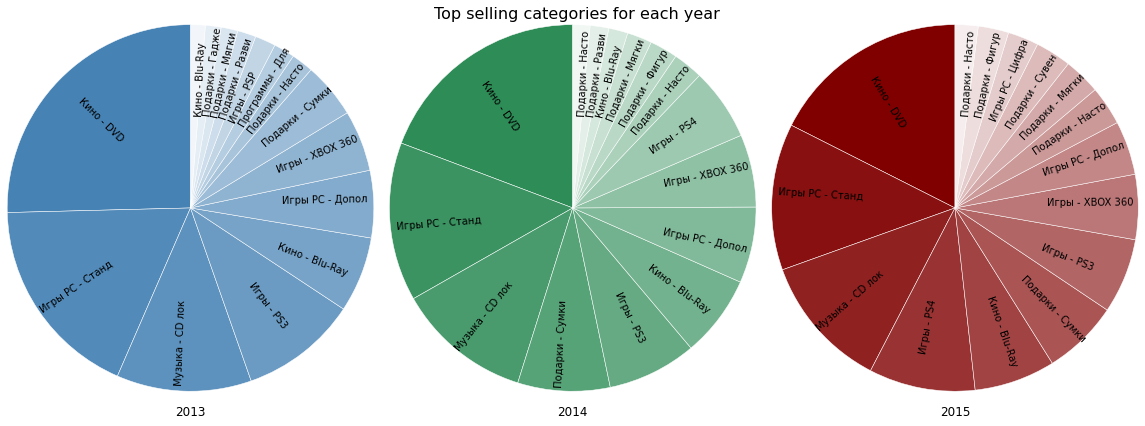

In [9]:
N=15

def get_ratio(year, topn, N):
    # Get total sold items for each year
    total = dfp.loc[year].item_cnt_year.sum()
    ratio = topn/total*100
    return "{0}: the total of the top {1} best selling items is {2} over a total of {3} for that year, which represents {4:.2f}%".format(year, N, topn, total, ratio)

dfp = sales[['date', 'item_id', 'item_cnt_day']].copy()
cats = item_categories.copy()

# Extract the year from the date column
dfp['year'] = pd.to_datetime(dfp['date'], format='%d.%m.%Y').dt.year
dfp.drop('date', axis=1, inplace=True)
dfp.item_cnt_day = dfp.item_cnt_day.astype(int)

# Remove returns
dfp = dfp[dfp.item_cnt_day>0]

# Add the category of each item
dfp = dfp.merge(items[['item_id','item_category_id']], how='left', on='item_id')

# Number of categories sold each year
dfp = dfp.groupby(['year', 'item_category_id'])\
       .agg({'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_year'}, inplace=False)

# Top N categories sold 
top = dfp['item_cnt_year'].groupby('year', group_keys=False).nlargest(N)
# Convert top to a dataframe
top = pd.DataFrame(top).reset_index()
# Add category type to be plotted lated
top = top.merge(cats[['item_category_id','item_category_name']], how='left', on='item_category_id')

# To print the top selling categories for each year
#print(top)

years = [2013, 2014, 2015]
fig, axes = plt.subplots(1, 3, figsize=(16,6))

#Prepare colors for the top N
colors = [[] for i in range(3)]
for alpha in np.arange(N, 0, -1)/N:
    colors[0].append((.275, .51, .706, alpha))
    colors[1].append((.18, .55, .34, alpha))
    colors[2].append((.5, 0, 0, alpha))
    
for ax, year, cs in zip(axes, years, colors):
    # Get top items for each year
    year_filter = top[top.year==year]
    plot_sizes = year_filter.item_cnt_year
    plot_labels = year_filter.item_category_name.str[:15]#+'('+plot_sizes.astype(str)+')'
    
    # Get the ratio
    print(get_ratio(year, plot_sizes.sum(), N))
    
    # Plot the pie
    ax.pie(plot_sizes, labels=plot_labels, radius=1.5, colors=cs,labeldistance=.5, rotatelabels=True, startangle=90, wedgeprops={"edgecolor":"1",'linewidth': .5})
    # Set titles below pies
    ax.set_title(year, y=-0.2)

# Space pies
fig.tight_layout()
fig.suptitle('Top selling categories for each year', fontsize=16)
plt.show()

del dfp

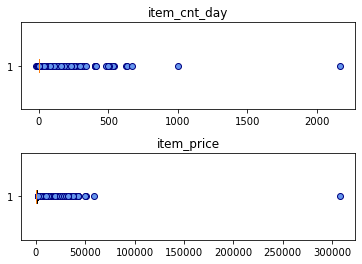

In [10]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=sales.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=sales.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

In [11]:
sales = sales[(sales.item_price<100000)&(sales.item_price>0)]
sales = sales[(sales.item_cnt_day>0)&(sales.item_cnt_day<1000)]

# Remove duplicate shops
sales.loc[sales.shop_id==0, 'shop_id'] = 57
test.loc[test.shop_id==0, 'shop_id'] = 57

sales.loc[sales.shop_id==1, 'shop_id'] = 58
test.loc[test.shop_id==1, 'shop_id'] = 58

sales.loc[sales.shop_id==10, 'shop_id'] = 11
test.loc[test.shop_id==10, 'shop_id'] = 11

In [12]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7я"', 'shop_name'] = 'СергиевПосад Тц "7я"'
shops['shop_city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops['shop_category'] = shops.shop_name.str.split(' ').map(lambda x: x[1])
shops.loc[shops.shop_city == '!Якутск', 'shop_city'] = 'Якутск'

In [13]:
shops['shop_city'] = LabelEncoder().fit_transform(shops.shop_city)
shops['shop_category'] = LabelEncoder().fit_transform(shops.shop_category)
shops = shops[['shop_id', 'shop_category', 'shop_city']]
shops.head()

,shop_id,shop_category,shop_city
0,0,4,29
1,1,9,29
2,2,9,0
3,3,7,1
4,4,9,2
